In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import constants as cs
from astropy import units as un
import sys
%matplotlib inline

In [25]:
if 0:
    r_3d,m1,m2,x,y,z=np.loadtxt('C:\\Users\Sophia Milanov\Documents\Bachelorarbeit\data\\x-y-z.dat', usecols=(1,9,10,30,31,32), unpack=True)
elif 1:
    r_3d,m1,m2,x,y,z=np.loadtxt('/home/sophia/Dokumente/Bachelorarbeit-2/x-y-z.dat', usecols=(1,9,10,30,31,32), unpack=True)
else:
    r_3d,m1,m2,x,y,z=np.loadtxt('/home/milanov/Bachelorarbeit/x-y-z.dat', usecols=(1,9,10,30,31,32), unpack=True)

In [26]:
mges=np.sum(m1+m2)
r3d0=r_3d[0]
m10=m1[0]
m20=m2[0]
x0=x[0]
y0=y[0]
z0=z[0]

r_3d=r_3d[1:]
m1=m1[1:]
m2=m2[1:]
x=x[1:]
y=y[1:]
z=z[1:]

In [4]:
r0=0.01
step=15
end=100
stepsize=((np.log10(end)-np.log10(r0))/step)
R=np.zeros(step)
r=np.logspace(np.log10(r0),np.log10(end),step+1)
r_i=r[:-1:]
r_a=r[1::]
binwidth=r_a-r_i
r_error=binwidth/2


In [5]:
M = np.zeros(step)
rho=np.zeros(step)

for n in range(step):
    inbin=(r_i[n]<r_3d) * (r_3d<=r_a[n]) #r_3d wird verwendet! creates boolean arrays woth true values if star is in bin distance
    M[n]=np.sum(m1[inbin])+np.sum(m2[inbin]) #mass array with both masses of binary system
    rho[n]=M[n]/((r_a[n]**2-r_i[n]**2)*np.pi) #calculates density of bin
    R[n]=np.mean(r_3d[inbin]) #calculates mean distance of bin
    
#extrabin am anfang
M_extra=np.sum(m1[r_3d<r0])+np.sum(m2[r_3d<r0])
rho_extra=M_extra/(r0**2*np.pi)
R_extra=np.mean(r_3d[r_3d<r0])
#einfuegen in bereits angefertigte arrays an erster Stelle
M_final=np.insert(M,0,M_extra)
rho_final=np.insert(rho,0,rho_extra)
R_final=np.insert(R,0,R_extra)

rho_relerror=-2*r_error/R_final[1:]
rho_error=rho_relerror*rho_final[1:]

s = interpolate.InterpolatedUnivariateSpline(np.log(R_final[:]), np.log(rho_final[:]))
R_new=np.logspace(-3,2,1000)
rho_int=np.exp(s(np.log(R_new)))


np.savetxt('densityfile.txt',(R_final,rho_final))


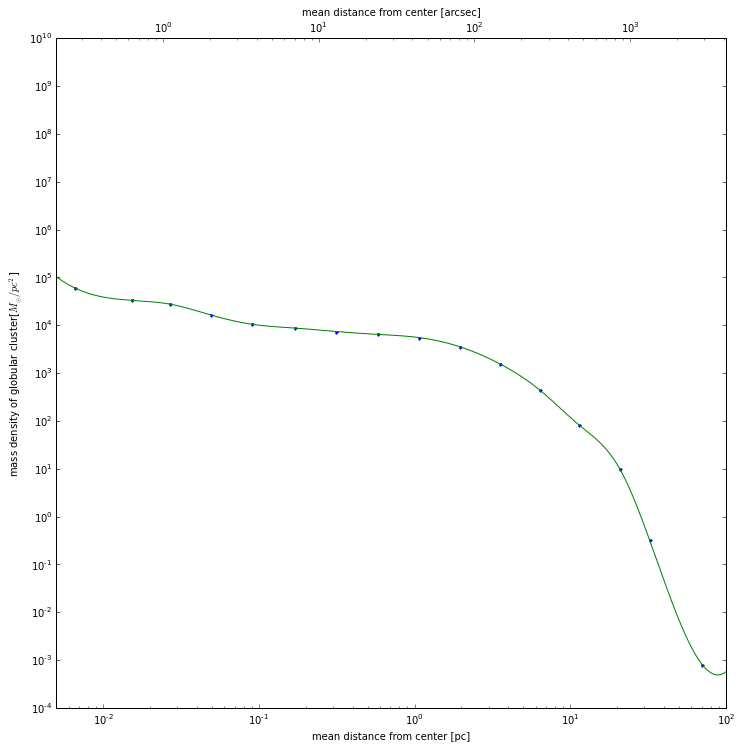

In [6]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.loglog(R_final,rho_final,'.')
ax1.loglog(R_new,rho_int)
ax1.set_xlim(0.005,100)
ax1.set_xlabel('mean distance from center [pc]')
ax1.set_ylabel('mass density of globular cluster[$M_\odot/pc^2$]')



ax2.set_xlim((0.005/5000)*360*3600/(2*np.pi),(100./5000)*360*3600/(2*np.pi)) #calculates x limits from parsec to arcsec
ax2.set_xscale('log')
ax2.set_xlabel('mean distance from center [arcsec]')

#fig.savefig('3d density profile numerical fit without imbh')

plt.show()


$\Phi(r)=4\pi G \int_{r}^{\infty}r''^2dr''\int_{0}^{r}\rho(r)r'^2dr'$

vereinfacht wegen Kugelsymmetrie: $\Phi(r)=-\frac{G}{r}\int_0^r{\mathrm{d}M(r')}-G\int_r^{\infty}{\frac{\mathrm{d}M(r')}{r'}}=-4\pi G\left[\frac{1}{r}\int_0^r\mathrm{d}r'r'^2\rho(r')+\int_r^{\infty}\mathrm{d}r'r'\rho(r')\right]$
rechne mit $f(r')=\rho(r')r'^2$ bzw. $f(r')=\rho(r')r'$


Gauss-Legendre quadrature

$\int_a^b f(x)dx = \frac{b-a}{2}\sum_{i=1}^n w_i f\left(\frac{b-a}{2}x_i+\frac{a+b}{2}\right)$

damit $\Phi(r)=-4\pi G\left[\frac{1}{2}\sum_{i=1}^n w_i\left(\frac{r}{2}x_i+\frac{r}{2}\right)^2\rho\left(\frac{r}{2} x_i+\frac{r}{2}\right)+\frac{\infty-r}{2}\sum_{i=1}^n w_i \left(\frac{\infty-r}{2} x_i + \frac{\infty+r}{2}\right)\rho\left(\frac{\infty-r}{2} x_i + \frac{\infty+r}{2}\right)\right]$

In [7]:
#G in pc^3/(M_sol*s^2)
m_3=un.m*un.m*un.m/(un.kg*un.s*un.s)
pc_3=un.pc**3/(un.solMass*un.s**2)
G=m_3.to(pc_3,cs.G)

In [8]:
#einfach s(x) benutzen

def potential(r,density,low=0.003,high=104.64,x_i=None,w_i=None):
    sum1=np.zeros(n)
    sum2=np.zeros(n)
    if isinstance(r,np.ndarray):
        return np.array([potential(rr,density,low=low,high=high,x_i=x_i,w_i=w_i) for rr in r])
    else:
        if r<low or r>high:
            sys.exit("r is smaller or bigger than star boundaries")
        x1=((r-low)/2)*x_i+(r+low)/2
        x2=((high-r)/2)*x_i+(high+r)/2
        for i in range(n):
            s1=density(x1[i])
            s2=density(x2[i])
            sum1[i]=(w_i[i]*x1[i]**2*s1)
            sum2[i]=(w_i[i]*x2[i]*s2)
        sum_1=np.sum(sum1)
        sum_2=np.sum(sum2)
        return -4*np.pi*G*((r-low)/(2*r)*sum_1+(high-r)/2*sum_2)
    

In [27]:
def potential_bh(r):
    return -G*(m10+m20)/r

In [19]:
#fuer w_i und x_i
n=30 #ab n=100 wurde diese Methode nicht getestet
x_i,w_i=np.polynomial.legendre.leggauss(n)
r=np.linspace(0.004,100,1000)
pot=potential_bh(r)+potential(r,s,x_i=x_i,w_i=w_i)

In [20]:
s1 = interpolate.InterpolatedUnivariateSpline(r, pot)


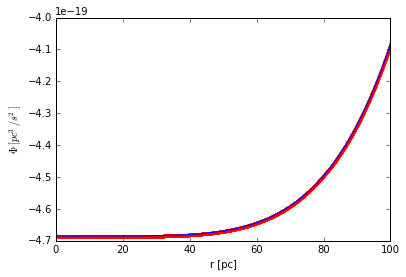

In [30]:
plt.plot(r,pot,'r.',r,s1(r),'b-')
#plt.xlim(0,120)
#plt.ylim(-4.7e-19,-4.0e-19)
plt.xlabel('r [pc]')
plt.ylabel('$\Phi\ [pc^3/s^2]$')

In [13]:
print(s1(r))

[ -4.68497129e-19  -4.68486157e-19  -4.68485942e-19  -4.68485868e-19
  -4.68485831e-19  -4.68485809e-19  -4.68485794e-19  -4.68485783e-19
  -4.68485775e-19  -4.68485768e-19  -4.68485763e-19  -4.68485759e-19
  -4.68485756e-19  -4.68485753e-19  -4.68485750e-19  -4.68485748e-19
  -4.68485746e-19  -4.68485745e-19  -4.68485743e-19  -4.68485742e-19
  -4.68485741e-19  -4.68485739e-19  -4.68485738e-19  -4.68485738e-19
  -4.68485737e-19  -4.68485736e-19  -4.68485735e-19  -4.68485734e-19
  -4.68485734e-19  -4.68485733e-19  -4.68485733e-19  -4.68485732e-19
  -4.68485732e-19  -4.68485731e-19  -4.68485731e-19  -4.68485730e-19
  -4.68485730e-19  -4.68485730e-19  -4.68485729e-19  -4.68485729e-19
  -4.68485729e-19  -4.68485728e-19  -4.68485728e-19  -4.68485728e-19
  -4.68485728e-19  -4.68485727e-19  -4.68485727e-19  -4.68485727e-19
  -4.68485727e-19  -4.68485727e-19  -4.68485727e-19  -4.68485726e-19
  -4.68485726e-19  -4.68485726e-19  -4.68485726e-19  -4.68485726e-19
  -4.68485726e-19  -4.68485726e-19

In [14]:
der=s1.derivative()


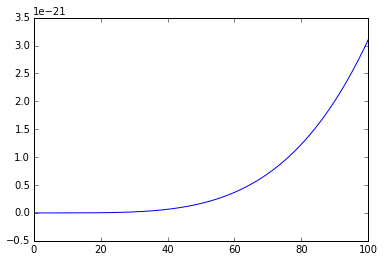

In [15]:
plt.plot(r,der(r))

In [29]:
print(potential_bh(0.01))

-4.56444666211e-24
